<a href="https://colab.research.google.com/github/mclcavalcante/hard-hat-detection/blob/main/helmet_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import os
import xml.etree.ElementTree as ET
from glob import glob

##Downloading and formating dataset

In [ ]:
!pip install -q kaggle

# Import OS for navigation and environment set up
import os
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d andrewmvd/hard-hat-detection


100% 1.22G/1.22G [00:15<00:00, 117MB/s]
100% 1.22G/1.22G [00:15<00:00, 86.5MB/s]


In [ ]:
!unzip -q 'hard-hat-detection.zip'

In [ ]:
!mkdir hard-hat-detection

!mv 'annotations' 'hard-hat-detection'
!mv 'images' 'hard-hat-detection'

In [ ]:
from glob import glob

xml_files = glob("hard-hat-detection/annotations/*.xml")

###Convert VOC format to COCO

In [ ]:
import xml.etree.ElementTree as ET
import os
import json

coco = dict()
coco['images'] = []
coco['type'] = 'instances'
coco['annotations'] = []
coco['categories'] = []

category_set = dict()
image_set = set()

category_item_id = 0
image_id = 20180000000
annotation_id = 0

def addCatItem(name):
    global category_item_id
    category_item = dict()
    category_item['supercategory'] = 'none'
    category_item_id += 1
    category_item['id'] = category_item_id
    category_item['name'] = name
    coco['categories'].append(category_item)
    category_set[name] = category_item_id
    return category_item_id

def addImgItem(file_name, size):
    global image_id
    if file_name is None:
        raise Exception('Could not find filename tag in xml file.')
    if size['width'] is None:
        raise Exception('Could not find width tag in xml file.')
    if size['height'] is None:
        raise Exception('Could not find height tag in xml file.')
    image_id += 1
    image_item = dict()
    image_item['id'] = image_id
    image_item['file_name'] = file_name
    image_item['width'] = size['width']
    image_item['height'] = size['height']
    coco['images'].append(image_item)
    image_set.add(file_name)
    return image_id

def addAnnoItem(object_name, image_id, category_id, bbox):
    global annotation_id
    annotation_item = dict()
    annotation_item['segmentation'] = []
    seg = []
    #bbox[] is x,y,w,h
    #left_top
    seg.append(bbox[0])
    seg.append(bbox[1])
    #left_bottom
    seg.append(bbox[0])
    seg.append(bbox[1] + bbox[3])
    #right_bottom
    seg.append(bbox[0] + bbox[2])
    seg.append(bbox[1] + bbox[3])
    #right_top
    seg.append(bbox[0] + bbox[2])
    seg.append(bbox[1])

    annotation_item['segmentation'].append(seg)

    annotation_item['area'] = bbox[2] * bbox[3]
    annotation_item['iscrowd'] = 0
    annotation_item['ignore'] = 0
    annotation_item['image_id'] = image_id
    annotation_item['bbox'] = bbox
    annotation_item['category_id'] = category_id
    annotation_id += 1
    annotation_item['id'] = annotation_id
    coco['annotations'].append(annotation_item)

def parseXmlFiles(xml_file):

    bndbox = dict()
    size = dict()
    current_image_id = None
    current_category_id = None
    file_name = None
    size['width'] = None
    size['height'] = None
    size['depth'] = None

    tree = ET.parse(xml_file)
    root = tree.getroot()
    if root.tag != 'annotation':
        raise Exception('pascal voc xml root element should be annotation, rather than {}'.format(root.tag))

    #elem is <folder>, <filename>, <size>, <object>
    for elem in root:
        current_parent = elem.tag
        current_sub = None
        object_name = None

        if elem.tag == 'folder':
            continue

        if elem.tag == 'filename':
            file_name = elem.text
            if file_name in category_set:
                raise Exception('file_name duplicated')

        #add img item only after parse <size> tag
        elif current_image_id is None and file_name is not None and size['width'] is not None:
            if file_name not in image_set:
                current_image_id = addImgItem(file_name, size)
            else:
                raise Exception('duplicated image: {}'.format(file_name))
        #subelem is <width>, <height>, <depth>, <name>, <bndbox>
        for subelem in elem:
            bndbox ['xmin'] = None
            bndbox ['xmax'] = None
            bndbox ['ymin'] = None
            bndbox ['ymax'] = None

            current_sub = subelem.tag
            if current_parent == 'object' and subelem.tag == 'name':
                object_name = subelem.text
                if object_name not in category_set:
                    current_category_id = addCatItem(object_name)
                else:
                    current_category_id = category_set[object_name]

            elif current_parent == 'size':
                if size[subelem.tag] is not None:
                    raise Exception('xml structure broken at size tag.')
                size[subelem.tag] = int(subelem.text)

            #option is <xmin>, <ymin>, <xmax>, <ymax>, when subelem is <bndbox>
            for option in subelem:
                if current_sub == 'bndbox':
                    if bndbox[option.tag] is not None:
                        raise Exception('xml structure corrupted at bndbox tag.')
                    bndbox[option.tag] = int(option.text)

            #only after parse the <object> tag
            if bndbox['xmin'] is not None:
                if object_name is None:
                    raise Exception('xml structure broken at bndbox tag')
                if current_image_id is None:
                    raise Exception('xml structure broken at bndbox tag')
                if current_category_id is None:
                    raise Exception('xml structure broken at bndbox tag')
                bbox = []
                #x
                bbox.append(bndbox['xmin'])
                #y
                bbox.append(bndbox['ymin'])
                #w
                bbox.append(bndbox['xmax'] - bndbox['xmin'])
                #h
                bbox.append(bndbox['ymax'] - bndbox['ymin'])
                # print('add annotation with {},{},{},{}'.format(object_name, current_image_id, current_category_id, bbox))
                addAnnoItem(object_name, current_image_id, current_category_id, bbox )

def build_coco_annot(xml_path, output_path):
    parseXmlFiles(xml_path)
    json.dump(coco, open(output_path, 'w'))

In [ ]:
%mkdir hard-hat-detection/cocoAnnotations

path_to_cocoAnnotatios = 'hard-hat-detection/cocoAnnotations/'
path_to_annotatios = 'hard-hat-detection/annotations/'

In [ ]:
count = 1
for f in os.listdir(path_to_annotatios):
    if not f.endswith('.xml'):
        continue
    path = f.split('.')
    build_coco_annot(path_to_annotatios+f, path_to_cocoAnnotatios + path[0] + ".json")

    #print  a counter to follow the progression
    print(count)
    count+=1

##Get dataset

In [ ]:
def xml_to_dict(xml_path):
    # Decode the .xml file
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # Return the image size, object label and bounding box
    # coordinates together with the filename as a dict.
    return {"filename": xml_path,
            "image_width": int(root.find("./size/width").text),
            "image_height": int(root.find("./size/height").text),
            "image_channels": int(root.find("./size/depth").text),
            "label": root.find("./object/name").text,
            "x1": int(root.find("./object/bndbox/xmin").text),
            "y1": int(root.find("./object/bndbox/ymin").text),
            "x2": int(root.find("./object/bndbox/xmax").text),
            "y2": int(root.find("./object/bndbox/ymax").text)}

In [ ]:
# Convert human readable str label to int.
label_dict = {"helmet": 1, "head" : 2, "person" : 3}
# Convert label int to human readable str.
reverse_label_dict = {1: "helmet", 2: "head", 3: "person"}
class HelmetDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None):
        """
        Inputs
            root: str
                Path to the data folder.
            transforms: Compose or list
                Torchvision image transformations.
        """
        self.root = root
        self.transforms = transforms
        self.files = sorted(os.listdir("images"))
        for i in range(len(self.files)):
            self.files[i] = self.files[i].split(".")[0]
            self.label_dict = label_dict
    def __getitem__(self, i):
        # Load image from the hard disc.
        img = PIL.Image.open(os.path.join(self.root,
              "images/" + self.files[i] + ".png")).convert("RGB")
        # Load annotation file from the hard disc.
        ann = xml_to_dict(os.path.join(self.root,
              "annotations/" + self.files[i] + ".xml"))
        # The target is given as a dict.
        target = {}
        target["boxes"] = torch.as_tensor([[ann["x1"],
                                            ann["y1"],
                                            ann["x2"],
                                            ann["y2"]]],
                                   dtype = torch.float32)
        target["labels"]=torch.as_tensor([label_dict[ann["label"]]],
                         dtype = torch.int64)
        target["image_id"] = torch.as_tensor(i)
        # Apply any transforms to the data if required.
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target
    def __len__(self):
        return len(self.files)


In [ ]:
import torchvision.transforms.functional as F
import torchvision.transforms.transforms as T
class Compose:
    """
    Composes several torchvision image transforms
    as a sequence of transformations.
    Inputs
        transforms: list
            List of torchvision image transformations.
    Returns
        image: tensor
        target: dict
    """
    def __init__(self, transforms = []):
        self.transforms = transforms
    # __call__ sequentially performs the image transformations on
    # the input image, and returns the augmented image.
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [ ]:
class ToTensor(torch.nn.Module):
    """
    Converts a PIL image into a torch tensor.
    Inputs
        image: PIL Image
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        image = F.pil_to_tensor(image)
        image = F.convert_image_dtype(image)
        return image, target
class RandomHorizontalFlip(T.RandomHorizontalFlip):
    """
    Randomly flips an image horizontally.
    Inputs
        image: tensor
        target: dict
    Returns
        image: tensor
        target: dict
    """
    def forward(self, image, target = None):
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                width, _ = F.get_image_size(image)
                target["boxes"][:, [0, 2]] = width - \
                                     target["boxes"][:, [2, 0]]
        return image, target

In [ ]:
def get_transform(train):
    """
    Transforms a PIL Image into a torch tensor, and performs
    random horizontal flipping of the image if training a model.
    Inputs
        train: bool
            Flag indicating whether model training will occur.
    Returns
        compose: Compose
            Composition of image transforms.
    """
    transforms = []
    # ToTensor is applied to all images.
    transforms.append(ToTensor())
    # The following transforms are applied only to the train set.
    if train == True:
        transforms.append(RandomHorizontalFlip(0.5))
        # Other transforms can be added here later on.
    return Compose(transforms)

In [ ]:
%cd hard-hat-detection
# Train dataset.
# Set train = True to apply the training image transforms.
train_ds = HelmetDataset("./", get_transform(train = True))
# Validation dataset.
val_ds = HelmetDataset("./", get_transform(train = False))
# Test dataset.
test_ds = HelmetDataset("./", get_transform(train = False))

%cd ..

In [ ]:
# Randomly shuffle all the data.
indices = torch.randperm(len(train_ds)).tolist()
# We split the entire data into 80/20 train-test splits. We further
# split the train set into 80/20 train-validation splits.
# Train dataset: 64% of the entire data, or 80% of 80%.
train_ds = torch.utils.data.Subset(train_ds,
           indices[:int(len(indices) * 0.64)])
# Validation dataset: 16% of the entire data, or 20% of 80%.
val_ds = torch.utils.data.Subset(val_ds,
         indices[int(len(indices) * 0.64):int(len(indices) * 0.8)])
# Test dataset: 20% of the entire data.
test_ds = torch.utils.data.Subset(test_ds,
          indices[int(len(indices) * 0.8):])

In [ ]:
# Collate image-target pairs into a tuple.
def collate_fn(batch):
    return tuple(zip(*batch))
# Create the DataLoaders from the Datasets.
train_dl = torch.utils.data.DataLoader(train_ds,
                                 batch_size = 4,
                                 shuffle = True,
                        collate_fn = collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds,
                             batch_size = 4,
                            shuffle = False,
                    collate_fn = collate_fn)
test_dl = torch.utils.data.DataLoader(test_ds,
                               batch_size = 4,
                              shuffle = False,
                      collate_fn = collate_fn)

##Get Faster RCNN pre-trained model from torchvision

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_object_detection_model(num_classes = 3,
                               feature_extraction = True):
    """
    Inputs
        num_classes: int
            Number of classes to predict. Must include the
            background which is class 0 by definition!
        feature_extraction: bool
            Flag indicating whether to freeze the pre-trained
            weights. If set to True the pre-trained weights will be
            frozen and not be updated during.
    Returns
        model: FasterRCNN
    """
    # Load the pretrained faster r-cnn model.
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
    # If True, the pre-trained weights will be frozen.
    if feature_extraction == True:
        for p in model.parameters():
            p.requires_grad = False
    # Replace the original 91 class top layer with a new layer
    # tailored for num_classes.
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats,
                                                   num_classes)
    return model

In [ ]:

def unbatch(batch, device):
    """
    Unbatches a batch of data from the Dataloader.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        X: list
            List of images.
        y: list
            List of dictionaries.
    """
    X, y = batch
    X = [x.to(device) for x in X]
    y = [{k: v.to(device) for k, v in t.items()} for t in y]
    return X, y
def train_batch(batch, model, optimizer, device):
    """
    Uses back propagation to train a model.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses
@torch.no_grad()
def validate_batch(batch, model, optimizer, device):
    """
    Evaluates a model's loss value using validation data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        optimizer: torch optimizer
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        loss: float
            Sum of the batch losses.
        losses: dict
            Dictionary containing the individual losses.
    """
    model.train()
    X, y = unbatch(batch, device = device)
    optimizer.zero_grad()
    losses = model(X, y)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [ ]:
def train_fasterrcnn(model,
                 optimizer,
                  n_epochs,
              train_loader,
        test_loader = None,
                log = None,
               keys = None,
            device = "cpu"):
    """
    Trains a FasterRCNN model using train and validation
    Dataloaders over n_epochs.
    Returns a Report on the training and validation losses.
    Inputs
        model: FasterRCNN
        optimizer: torch optimizer
        n_epochs: int
            Number of epochs to train.
        train_loader: DataLoader
        test_loader: DataLoader
        log: Record
            torch_snippet Record to record training progress.
        keys: list
            List of strs containing the FasterRCNN loss names.
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        log: Record
            torch_snippet Record containing the training records.
    """
    if log is None:
        log = Report(n_epochs)
    if keys is None:
        # FasterRCNN loss names.
        keys = ["loss_classifier",
                   "loss_box_reg",
                "loss_objectness",
               "loss_rpn_box_reg"]
    model.to(device)
    for epoch in range(n_epochs):
        N = len(train_loader)
        for ix, batch in enumerate(train_loader):
            loss, losses = train_batch(batch, model,
                                  optimizer, device)
            # Record the current train loss.
            pos = epoch + (ix + 1) / N
            log.record(pos = pos, trn_loss = loss.item(),
                       end = "\r")
        if test_loader is not None:
            N = len(test_loader)
            for ix, batch in enumerate(test_loader):
                loss, losses = validate_batch(batch, model,
                                         optimizer, device)

                # Record the current validation loss.
                pos = epoch + (ix + 1) / N
                log.record(pos = pos, val_loss = loss.item(),
                           end = "\r")
    log.report_avgs(epoch + 1)
    return log

In [ ]:
!pip install torch_snippets

In [ ]:
from torch_snippets import Report
import PIL

# Create the faster rcnn model with 3 classes - helmet, person and head
model = get_object_detection_model(num_classes = 3,
                        feature_extraction = False)
# Use the stochastic gradient descent optimizer.
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                        lr = 0.005,
                    momentum = 0.9,
             weight_decay = 0.0005)
# Train the model over 1 epoch.
log = train_fasterrcnn(model = model,
               optimizer = optimizer,
                        n_epochs = 1,
             train_loader = train_dl,
                test_loader = val_dl,
             log = None, keys = None,
                       device = 'gpu')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EPOCH: 1.000  trn_loss: 0.387  val_loss: 0.247  (786.60s - 0.00s remaining)


##Predictions

In [ ]:
@torch.no_grad()
def predict_batch(batch, model, device):
    """
    Gets the predictions for a batch of data.
    Inputs
        batch: tuple
            Tuple containing a batch from the Dataloader.
        model: torch model
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the
            bounding boxes, labels and confidence scores.
    """
    model.to(device)
    model.eval()
    X, _ = unbatch(batch, device = device)
    predictions = model(X)
    return [x.cpu() for x in X], predictions
def predict(model, data_loader, device = "cpu"):
    """
    Gets the predictions for a batch of data.
    Inputs
        model: torch model
        data_loader: torch Dataloader
        device: str
            Indicates which device (CPU/GPU) to use.
    Returns
        images: list
            List of tensors of the images.
        predictions: list
            List of dicts containing the predictions for the
            bounding boxes, labels and confidence scores.
    """
    images = []
    predictions = []
    for i, batch in enumerate(data_loader):
        X, p = predict_batch(batch, model, device)
        images = images + X
        predictions = predictions + p

    return images, predictions


In [ ]:
def decode_prediction(prediction,
                      score_threshold = 0.8,
                      nms_iou_threshold = 0.2):
    """
    Inputs
        prediction: dict
        score_threshold: float
        nms_iou_threshold: float
    Returns
        prediction: tuple
    """
    boxes = prediction["boxes"]
    scores = prediction["scores"]
    labels = prediction["labels"]
    # Remove any low-score predictions.
    if score_threshold is not None:
        # want = scores > score_threshold
        want = max(scores)
        boxes = boxes[(scores == want).nonzero(as_tuple=True)[0]]
        scores = scores[(scores == want).nonzero(as_tuple=True)[0]]
        labels = labels[(scores == want).nonzero(as_tuple=True)[0]]
    # Remove any overlapping bounding boxes using NMS.
    if nms_iou_threshold is not None:
        want = torchvision.ops.nms(boxes = boxes, scores = scores,
                                iou_threshold = nms_iou_threshold)
        boxes = boxes[want]
        scores = scores[want]
        labels = labels[want]

    return (boxes.cpu().numpy(),
            labels.cpu().numpy(),
            scores.cpu().numpy())


In [ ]:
images, predictions = predict(model, test_dl, device='gpu')

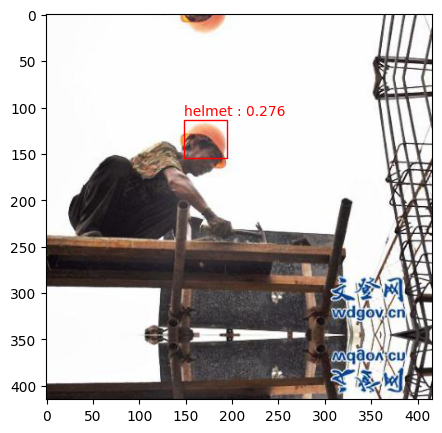

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img_index = 0
boxes, labels, scores = decode_prediction(predictions[img_index])
fig, ax = plt.subplots(figsize = [5, 5])
ax.imshow(images[img_index].permute(1, 2, 0).numpy())
for i, b in enumerate(boxes):
    rect = patches.Rectangle(b[:2].astype(int),
                             (b[2] - b[0]).astype(int),
                             (b[3] - b[1]).astype(int),
                             linewidth = 1,
                             edgecolor = "r",
                             facecolor = "none")
    ax.add_patch(rect)
    ax.text(b[0].astype(int),
            b[1].astype(int) - 5,
            "{} : {:.3f}".format(reverse_label_dict[labels[i]],
            scores[i]), color = "r")
plt.show()